In [314]:
# Import packages:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import linregress

from IPython.display import Image

# Section 1: Data Gathering and Wrangling
### Under zipcode level
Combine all table together get the finalized table

## Import existing datasets
1. Zip_irs_table: zipcodes with housevalue, income and irs tax values
2. Luxury: luxury shop locations and sale volumns
3. Private school: location and number of school under each zipcode
4. Hospital data: location and number of hospital under each zipcode
5. Airport data: location and number of airport under each zipcode 
6. Age distribution data: under state level
7. State tax rate data: state tax rate & averge local tax rate 
8. Demographic data: gender, income, ethnic data and transit score data



## Study trend data
9. Trend data include unemployee rate trend and labor force trend under county level
10. Business pattern trend data 

In [96]:
# zip_county_data with irs data
zip_base=pd.read_csv('../Data/zip_base.csv')
exist_branches=pd.read_csv('../Data/exist_branches.csv')
ubs_city=pd.read_csv('../Data/UBS_location.csv')

# wealth indicators, other zip related characterists
luxury=pd.read_csv('../Data/luxury.csv')
private_school=pd.read_csv('../Data/private_school.csv')
hospital=pd.read_csv('../Data/hospital.csv')
airport=pd.read_csv('../Data/airport.csv')

state_tax=pd.read_csv('../Data/state tax rate.csv','\t')
startup=pd.read_csv('../Data/startups.csv')
age=pd.read_csv('../Data/State_age_distribution.csv')
demographic=pd.read_csv('../Data/acs2015_county_data.csv')

zip_county=pd.read_csv('../Data/ZIP-COUNTY-FIPS_2017-06.csv')
county_firms=pd.read_csv('../Data/county_firm_total.csv')



In [97]:
##  modify zipcodes from integers to zipcodes format
exist_branches['ZIP Code'] = exist_branches['ZIP Code'].astype(str).str.zfill(5)
ubs_city['Zip'] = ubs_city['Zip'].astype(str).str.zfill(5)

zip_base['zip_x']=zip_base['zip_x'].astype(str).str.zfill(5)
zip_base=zip_base.rename(columns={'branch.1':'branch'})
zip_base['cbsa'] = zip_base['cbsa'].astype(str).str.zfill(5)
zip_base.state=zip_base.state.str.title()

luxury['ZIP Code'] = luxury['ZIP Code'].astype(str).str.zfill(5)
private_school['ZIP'] = private_school['ZIP'].astype(str).str.zfill(5)
hospital['ZIP'] = hospital['ZIP'].astype(str).str.zfill(5)
airport['zip_x']=airport['zip_x'].astype(str).str.zfill(5)

zip_county['ZIP'] = zip_county['ZIP'].astype(str).str.zfill(5)
county_firms['cbsacode']=county_firms['cbsacode'].astype(str).str.zfill(5)


In [98]:
#CensusId==STCOUNTYFP

demographic = demographic.drop(['State','County'], axis=1)
demographic = pd.merge(demographic, zip_county,  how='left', left_on=['CensusId'], right_on = ['STCOUNTYFP'])

demographic['ZIP'] = demographic['ZIP'].astype(str).str.zfill(5)
demo=demographic[['Men', 'Women', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment', 'ZIP']].drop_duplicates()
demo=demo.groupby('ZIP').mean().reset_index().drop_duplicates()

In [99]:
# get zip level sales level from UBS and other wealth managaement branches
exist_zip=exist_branches[['ZIP Code','Location Sales Volume Actual']]
exist_zip.columns=['zip','zip_sales_volume']
exist_zip.zip_sales_volume=exist_zip.zip_sales_volume.replace('[\$,]', '', regex=True).astype(float)

exist_zip=exist_zip.groupby('zip')['zip_sales_volume'].sum().reset_index()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [100]:
luxury=luxury[['ZIP Code','Location Sales Volume Actual']]
luxury.columns=['zip','luxury_sales_volume']
luxury['luxury_sales_volume']=luxury['luxury_sales_volume'].replace('[\$,]', '', regex=True).astype(float)
luxury=luxury.groupby('zip').sum().reset_index()

private_school=pd.DataFrame(private_school.groupby('ZIP')['ENROLLMENT'].sum()).reset_index()
private_school.columns=['zip','school_enrollment']

hospital=pd.DataFrame(hospital.groupby('ZIP')['BEDS'].sum()).reset_index()
hospital.columns=['zip','hospital_beds']

airport=pd.DataFrame(airport.groupby('zip_x')['no_airport'].sum()).reset_index()
airport.columns=['zip','no_airport']

state_tax=state_tax[['State ID','State Tax Rate','Avg. Local Tax Rate (a)']]
state_tax.columns=['state_id','state_tax','avg_local_tax']
state_tax.state_tax=state_tax.state_tax.replace('[\%,]', '', regex=True).astype(float)
state_tax.avg_local_tax=state_tax.avg_local_tax.replace('[\%,]', '', regex=True).astype(float)

startup=startup[['Location','Startups','Followers','Investors','Jobs']]
startup.columns=['state','no_startups','no_followers','no_nvestors','no_startup_jobs']

age = age.iloc[1:]
age=age.drop(['Location','Total'],axis=1)


county_firms=county_firms[['cbsacode','TOTAL NUMBER OF FIRMS','NUMBER OF ESTABLISHMENTS','COUNTY_FIRM_EMPLOYMENT','ANNUAL_FIRM_PAYROLL ($1,000)']]
county_firms=county_firms.groupby('cbsacode').sum().reset_index()


In [101]:
df=zip_base.merge(luxury,how='left', left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)
df1=df.merge(private_school, how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)
df2=df1.merge(hospital, how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)
df3=df2.merge(airport, how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)
df4=df3.merge(state_tax, how='left', left_on='state_code', right_on='state_id').drop(['state_id'],axis=1)
df5=df4.merge(startup, how='left', left_on='state', right_on='state').fillna(0)#.drop(['state'],axis=1)
df6=df5.merge(age, how='left', left_on='state_code', right_on='State ID').fillna(0).drop(['State ID'],axis=1)
df7=df6.merge(demo, how='left', left_on='zip_x', right_on='ZIP').fillna(0).drop(['ZIP'],axis=1)
df8=df7.merge(exist_zip, how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)
df9=df8.merge(county_firms, how='left',left_on='cbsa', right_on='cbsacode').fillna(0).drop(['cbsacode'],axis=1)


## Trend data analysis - part 1
County level: 
Employeement data: from 1990-2018
1. unemployee rate
2. labor force


In [102]:
unemployment=pd.read_csv('../Data/Unemployment_data_Metro.csv')

unemployment=unemployment.drop(['State FIPS Code','LAUS Code','Area','Unnamed: 10','Unnamed: 11','Employment','Unemployment'], axis=1)
unemployment=unemployment.drop_duplicates()
unemployment=unemployment.dropna()


In [103]:
unemployment.head()


,Area FIPS Code,Year,Month,Civilian Labor Force,Unemployment Rate
0,11500.0,2018.0,1.0,"45,305",4.3
1,12220.0,2018.0,1.0,"73,161",3.3
2,13820.0,2018.0,1.0,"531,767",3.3
3,19300.0,2018.0,1.0,"91,819",3.3
4,19460.0,2018.0,1.0,"68,008",3.5


In [104]:
# generate the date column for all records
unemployment.Year=unemployment.Year.astype(int)
unemployment.Month=unemployment.Month.astype(int)
unemployment['Day']=1
unemployment['Date'] = unemployment.apply(lambda row: datetime(row['Year'], row['Month'], row['Day']), axis=1)
unemployment.sort_values(by=['Date'], inplace=True, ascending=True)

In [105]:
unemployment=unemployment[['Area FIPS Code','Date','Civilian Labor Force','Unemployment Rate']]
unemployment.columns=['FIPS_code','Date','labor_force','unemployment_rate']
unemployment.head()

,FIPS_code,Date,labor_force,unemployment_rate
131138,41900.0,1990-01-01,"40,124",20.7
131012,30020.0,1990-01-01,"45,174",5.4
131011,21420.0,1990-01-01,"26,979",4.3
131010,49660.0,1990-01-01,"283,549",6.6
131009,48260.0,1990-01-01,"60,410",5.9


In [106]:
# assume date count from start from 1989-12-31
Date=datetime(1989,12,31)
delta = abs(unemployment.Date - Date) #unemployment.Date[131009]

unemployment['days']=delta.astype('timedelta64[D]')
unemployment.labor_force=unemployment.labor_force.replace('[\,]', '', regex=True).astype(int)


In [107]:
# use slope from linear regression as trend value
from scipy.stats import linregress

unemployment_rate=unemployment.groupby('FIPS_code').apply(lambda v: linregress(v.days, v['unemployment_rate'])[0])
labor_force=unemployment.groupby('FIPS_code').apply(lambda v: linregress(v.days, v['labor_force'])[0])

In [108]:
unemployment_rate=pd.DataFrame(unemployment_rate).reset_index()
labor_force=pd.DataFrame(labor_force).reset_index()

trend=unemployment_rate.merge(labor_force, on='FIPS_code')
trend.columns=['FIPS_code','unemployment_rate_trend','labor_force_trend']
trend.unemployment_rate_trend=trend.unemployment_rate_trend
trend.to_csv('../Output/employee_trend.csv',index=False)

In [109]:
trend.tail()


,FIPS_code,unemployment_rate_trend,labor_force_trend
390,76900.0,-0.000036,2.129820
391,77200.0,0.000024,5.607380
392,78100.0,0.000035,1.859056
393,78700.0,0.000164,-0.065368
394,79600.0,-0.000037,7.029574


## Trend data analysis - part 2

Zipcode level:
Business patterns data: from 2011-2016
1. number of establishments: business and companies
2. number of employee
3. quarter 1 payroll 
4. annual payroll 

In [110]:
business_pattern=pd.read_csv('../Data/business_pattern.csv')
business_pattern.head()

,ZIPCODE,YEAR,ESTABLISHMENTS,EMPLOYEE,PAYQTR1,PAY_ANNUAL(1000)
0,35004,2011,155,2170,17772,78514
1,35005,2011,91,650,4353,19662
2,35006,2011,21,0,0,0
3,35007,2011,581,9615,73010,326283
4,35010,2011,467,7303,51157,217861


In [111]:
no_establishments=business_pattern.groupby('ZIPCODE').apply(lambda v: linregress(v.YEAR, v['ESTABLISHMENTS'])[0]).drop_duplicates()
employee_trend=business_pattern.groupby('ZIPCODE').apply(lambda v: linregress(v.YEAR, v['EMPLOYEE'])[0]).drop_duplicates()
pay_quarter1_trend=business_pattern.groupby('ZIPCODE').apply(lambda v: linregress(v.YEAR, v['PAYQTR1'])[0]).drop_duplicates()
pay_annual_trend=business_pattern.groupby('ZIPCODE').apply(lambda v: linregress(v.YEAR, v['PAY_ANNUAL(1000)'])[0]).drop_duplicates()

no_establishments=pd.DataFrame(no_establishments).reset_index()
employee_trend=pd.DataFrame(employee_trend).reset_index()
pay_quarter1_trend=pd.DataFrame(pay_quarter1_trend).reset_index()
pay_annual_trend=pd.DataFrame(pay_annual_trend).reset_index()

/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [112]:
# combine the trends together
bp_trend1=no_establishments.merge(employee_trend, on='ZIPCODE',how='right').fillna(0)
bp_trend2=bp_trend1.merge(pay_quarter1_trend, on='ZIPCODE',how='right').fillna(0)
bp_trend3=bp_trend2.merge(pay_annual_trend, on='ZIPCODE',how='right').fillna(0)


In [113]:
bp_trend3.columns=['zip','no_establishments_trend','employee_trend','pay_quarter1_trend','pay_annual_trend']
bp_trend3.to_csv('../Output/business_pattern_trend.csv',index=False)

In [114]:
# business pattern trend
bp_trend3.head()

,zip,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend
0,501,0.057143,0.000000,0.000000,0.000000
1,1001,6.028571,91.742857,2095.257143,9215.257143
2,1002,0.428571,638.742857,5178.657143,23209.657143
3,1003,1.057143,19.914286,52.771429,351.885714
4,1004,-1.057143,22.800000,-64.742857,-116.571429


## Keep combine all data together
- Add trend data to previous table

In [115]:
employee_trend=pd.read_csv('../Output/employee_trend.csv')
business_trend=pd.read_csv('../Output/business_pattern_trend.csv')

trend['FIPS_code'] = trend['FIPS_code'].astype(int)
trend['FIPS_code'] = trend['FIPS_code'].astype(str).str.zfill(5)
business_trend['zip']=business_trend['zip'].astype(str).str.zfill(5)

In [116]:
df10=df9.merge(trend, how='left', left_on='cbsa', right_on='FIPS_code').fillna(0).drop(['FIPS_code'],axis=1)
final_table=df10.merge(business_trend, how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip'],axis=1)


In [23]:
len(final_table)
final_table.to_csv('../Output/final_table.csv',index=False)

# this is the version dont have competitor sales

37328

In [119]:
final_table.head()
# without sales

,zip_x,cbsa,city,state,state_code,county,population,populationDensity,housingUnits,medianHomeValue,...,TOTAL NUMBER OF FIRMS,NUMBER OF ESTABLISHMENTS,COUNTY_FIRM_EMPLOYMENT,"ANNUAL_FIRM_PAYROLL ($1,000)",unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend
0,99553,99999,Akutan,Alaska,AK,Aleutians East Borough,1027,74,44,112500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-23.314286
1,99612,99999,King Cove,Alaska,AK,Aleutians East Borough,938,80,229,112500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,99661,99999,Sand Point,Alaska,AK,Aleutians East Borough,978,5,292,122800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,409.400000,2385.028571
3,99660,99999,Saint Paul Island,Alaska,AK,Aleutians West Census Area,479,12,190,88900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-94.485714,-382.542857,-1151.228571
4,99685,99999,Unalaska,Alaska,AK,Aleutians West Census Area,4224,71,1001,317100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,257.171429,634.514286


In [25]:
from IPython.display import Image


 <font color='green'>Slides from here -------------------------------------------------------------------------------------------</font> 

<img src="../Picture/slide1.PNG" width="90%">

<img src="../Picture/slide2.PNG" width="90%">

<img src="../Picture/slide3.PNG" width="90%">

<img src="../Picture/slide4.PNG" width="90%">

<img src="../Picture/slide5.PNG" width="90%">

<img src="../Picture/slide6.PNG" width="90%">

<img src="../Picture/slide7.PNG" width="90%">

<img src="../Picture/slide8.PNG" width="90%">

<img src="../Picture/chapter3.PNG" width="90%">

<img src="../Picture/data_challenge.PNG" width="90%">

<img src="../Picture/ml_challenges.PNG" width="90%">

<img src="../Picture/ml_approaches_1.PNG" width="90%">

<img src="../Picture/ml_approaches_2.PNG" width="90%">

<img src="../Picture/ml_overview.PNG" width="90%">

<img src="../Picture/kmeans.PNG" width="90%">


### Perpare the data for k-means clustering use
- select 5 features for each zipcode for analysis
1. population
2. median house value
3. median household income
4. number of competitors in the zipcode
5. wealth management branch sales volume 

In [26]:
zip_data=final_table[['zip_x','state','city','population',
                        'medianHomeValue','medianHouseholdIncome',
                      'zip_sales_volume']].rename(columns={'zip_x':'zip'})

In [27]:
zip_data.tail()


,zip,state,city,population,medianHomeValue,medianHouseholdIncome,zip_sales_volume
37323,82442,Wyoming,Ten Sleep,732,172800.0,40938.0,0.0
37324,82701,Wyoming,Newcastle,5455,142200.0,52207.0,0.0
37325,82701,Wyoming,Newcastle,5455,142200.0,52207.0,0.0
37326,82723,Wyoming,Osage,278,80000.0,58347.0,0.0
37327,82730,Wyoming,Upton,1566,166900.0,65848.0,0.0


In [28]:
exist_branches=pd.read_csv('../Data/exist_branches.csv')
competitors=exist_branches[(exist_branches['Company Name']!='UBS')]
competitors['ZIP Code'] = competitors['ZIP Code'].astype(str).str.zfill(5)
competitors=competitors.rename(columns={'ZIP Code':'zip'})
len(competitors)

num_comp=competitors.groupby(['zip']).size().reset_index()
num_comp.columns=['zip','no_competitor']
competitors=pd.merge(competitors,num_comp,on='zip',how='left')
competitors=competitors[['zip','no_competitor']]
competitors.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2576

,zip,no_competitor
0,99503,3
1,99801,1
2,36201,1
3,35242,2
4,35242,2


In [29]:
cluster_data=pd.merge(zip_data,competitors, on='zip',how='left').fillna(0).drop_duplicates()
cluster=cluster_data.drop(['state','city'],axis=1).set_index('zip')

len(cluster)

29652

In [30]:
# data for clustering: 

cluster.head()


,population,medianHomeValue,medianHouseholdIncome,zip_sales_volume,no_competitor
zip,,,,,
99553,1027,112500.0,38333.0,0.0,0.0
99612,938,112500.0,62917.0,0.0,0.0
99661,978,122800.0,71250.0,0.0,0.0
99660,479,88900.0,38750.0,0.0,0.0
99685,4224,317100.0,89853.0,0.0,0.0


### Number of clusters as a variable

#### Here selected 6 clusters

In [31]:
# distance between any pair of documents
#dist = 1 - cosine_similarity(dtm)

scaler = StandardScaler() #MinMaxScaler()
scaled_data = scaler.fit_transform(cluster)

num_cluster=6
# Number of clusters
kmeans = KMeans(n_clusters=num_cluster) #,random_state=42
# Fitting the input data
kmeans = kmeans.fit(scaled_data)
# Getting the cluster labels
labels = kmeans.predict(scaled_data)
# Centroid values
centroids = kmeans.cluster_centers_


In [32]:
cluster_data['cluster']=labels

cluster_summary  = pd.DataFrame(columns = ['num_member', 'medianIncome', 'population','medianHomeValue','no_competitor','zip_sales_volume'])

for i in range(num_cluster):
    globals()['group' + str(i)]=cluster_data[(cluster_data.cluster==i)]
    cluster_summary=cluster_summary.append(pd.Series([len(globals()['group' + str(i)]),
                                     globals()['group' + str(i)].medianHouseholdIncome.mean(),
                                     globals()['group' + str(i)].population.mean(),
                           globals()['group' + str(i)].medianHomeValue.mean(),  #quantile(.75)
    globals()['group' + str(i)].no_competitor.mean(),
                                globals()['group' + str(i)].zip_sales_volume.mean()],
                            index=['num_member', 'medianIncome', 'population','medianHomeValue','no_competitor','zip_sales_volume']), ignore_index=True) 


In [33]:
ubs_city=pd.read_csv('/Users/shutingzhang/Desktop/Data Competitions/UBS project/Data/UBS_location.csv')
ubs_city['Zip'] = ubs_city['Zip'].astype(str).str.zfill(5)
ubs_city.columns = ['city', 'state','zip']
#ubs_city['branch']=ubs_city.apply(lambda _: 1, axis=1)

In [34]:
cluster_summary.medianIncome=round(cluster_summary.medianIncome,2)

cluster_summary.population=round(cluster_summary.population,1)

cluster_summary.medianHomeValue=round(cluster_summary.medianHomeValue,2)

cluster_summary.no_competitor=round(cluster_summary.no_competitor,2)

cluster_summary.zip_sales_volume=round(cluster_summary.zip_sales_volume,2)


In [35]:
# clustering results: 
cluster_summary

,num_member,medianIncome,population,medianHomeValue,no_competitor,zip_sales_volume
0,17182.0,41471.09,4117.0,104919.10,0.01,2.861756e+04
1,4032.0,52347.14,37735.4,195218.92,0.10,6.158596e+05
2,23.0,96139.43,14982.5,555056.84,5.48,2.596213e+08
3,1604.0,106744.43,15729.9,590110.54,0.11,9.557724e+05
4,6258.0,68704.79,7024.5,235710.62,0.02,1.505511e+05
5,553.0,62353.68,26026.0,289757.44,2.93,2.922895e+07


Text(0.5,0,'# of Cluster')

Text(0,0.5,'# of UBS branches')

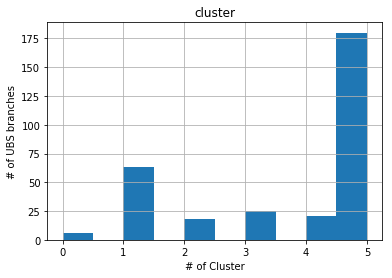

In [36]:
# How UBS branches falling into each clusters

ubs_summary=pd.merge(ubs_city,cluster_data,on='zip', how='left').drop_duplicates()
axarr=ubs_summary.hist(column="cluster")
for ax in axarr.flatten():
    ax.set_xlabel("# of Cluster")
    ax.set_ylabel("# of UBS branches")

Text(0.5,0,'# of Cluster')

Text(0,0.5,'# of competitor branches')

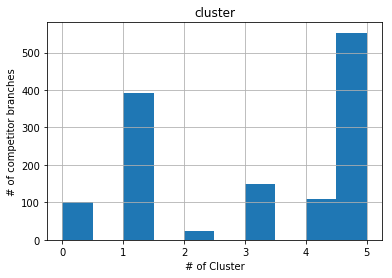

In [37]:
# How competitor branches falling into clusters
comp_summary=pd.merge(competitors,cluster_data,on='zip', how='left').drop_duplicates()
axarr1=comp_summary.hist(column="cluster")
for ax in axarr1.flatten():
    ax.set_xlabel("# of Cluster")
    ax.set_ylabel("# of competitor branches")

## UBS locations and competitors locations are in same trend of clusters

- pick the top clusters which UBS locations falling into

In [38]:
top_clusters=np.array(ubs_summary.groupby('cluster').size()).argsort()[-3:][::-1]
top_clusters=top_clusters.tolist()


# check clusters find out that cluster 2 have high zip_sales_volume 
top_sales_clusters=np.array(cluster_summary.zip_sales_volume).argsort()[-3:][::-1].tolist()
possible_cluster=list(set(top_clusters)|set(top_sales_clusters))



In [39]:
possible_cluster

[1, 2, 3, 5]

In [40]:
bottom_clusters=np.array(ubs_summary.groupby('cluster').size()).argsort()[:1]
bottom_clusters=bottom_clusters.tolist()
bottom_clusters

[0]

### Since we are looking for the potential locations, we will only use locations from top clusters and competitor locations for further analysis.
* not including the current UBS locations and overlapping locations between UBS and competitors

In [41]:
zip_cluster=cluster_data[(cluster_data.cluster.isin(possible_cluster))]
zip_cluster=zip_cluster[['zip']]
competitor_zip=competitors[['zip']]

to_drop=ubs_city['zip'] 

possible=pd.concat([competitor_zip,zip_cluster])
possible.drop(possible.loc[possible['zip'].isin(to_drop)].index, inplace=True)

len(possible)
possible.to_csv('../Output/possible locations after clustering.csv',index=False)


7583

In [42]:
non_target_locations=cluster_data[(cluster_data.cluster.isin(bottom_clusters))]
non_target_locations=non_target_locations[['zip']]
#non_target_locations.head()

to_drop=ubs_city['zip'] 
non_target_locations.drop(non_target_locations.loc[non_target_locations['zip'].isin(to_drop)].index, inplace=True)
len(non_target_locations)

17176

<img src="../Picture/cosine.PNG" width="90%">

# Section 3: 2nd 2nd round zipcode shortlisting
## Before optimizating any machine learning models
## Using Cosine Similarity for 2nd round short-listing

### Take very long to run, here are pre-calculated data

# can use final_table directly: 


In [120]:



possible=pd.read_csv('../Output/possible locations after clustering.csv')
ubs_classification=pd.read_csv('../Output/ubs_branch_classification.csv')

In [44]:
cos_dataset=final_table.drop(['cbsa','city','state','state_code','county'], axis=1).drop_duplicates()
cos_dataset['zip_x'] = cos_dataset['zip_x'].astype(str).str.zfill(5)
cos_dataset=cos_dataset.set_index('zip_x')

In [45]:
# standardize the data for cosine similarity calculation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cos_dataset)

# calculate the cosine similarity of all locations
cosine_sim=cosine_similarity(scaled_data)


In [46]:
cosine_sim = pd.DataFrame(cosine_sim)
zip_x=cos_dataset.index
cosine_sim['zip']=zip_x
cosine_sim=cosine_sim.set_index('zip')


In [47]:
cosine_sim.columns = cos_dataset.index
cosine_sim.head()


zip_x,99553,99612,99661,99660,99685,99692,99501,99502,99503,99504,...,82933,82937,82939,82944,82401,82442,82701,82701,82723,82730
zip,,,,,,,,,,,,,,,,,,,,,
99553,1.000000,0.999046,0.998365,0.936012,0.929654,0.931218,0.111478,0.055121,0.087488,0.011080,...,0.173999,0.161788,0.163023,0.172137,0.302968,0.321179,0.103539,0.103583,0.221693,0.210766
99612,0.999046,1.000000,0.999141,0.934911,0.932125,0.932883,0.116431,0.061623,0.088748,0.018694,...,0.169017,0.165420,0.165531,0.167296,0.301539,0.316500,0.102318,0.102362,0.221221,0.211241
99661,0.998365,0.999141,1.000000,0.934514,0.933616,0.934614,0.112728,0.061742,0.087253,0.014024,...,0.171654,0.171541,0.172817,0.167938,0.307964,0.320754,0.120240,0.120281,0.218482,0.218778
99660,0.936012,0.934911,0.934514,1.000000,0.990397,0.993054,0.255409,0.152116,0.196590,0.063630,...,0.250909,0.234478,0.239787,0.242259,0.317447,0.343838,0.144856,0.144921,0.217611,0.249621
99685,0.929654,0.932125,0.933616,0.990397,1.000000,0.995089,0.262825,0.174222,0.197691,0.074086,...,0.241339,0.249559,0.250883,0.237666,0.312687,0.334642,0.145057,0.145121,0.213571,0.255400


In [48]:
ubs_classification.zip=ubs_classification.zip.astype(str).str.zfill(5)
ubs_zip=list(ubs_classification.zip)

round1=cosine_sim[ubs_zip]  # columns with UBS branches

round2=round1[~round1.index.isin(ubs_zip)]  # rows wih non ubs locations

possible.zip=possible.zip.astype(str).str.zfill(5)   # from first k-means possible zupcode 


# just to check how possible zipcodes are similar to the existing UBS locations
round3=round2[round2.index.isin(list(possible.zip))]

 
len(round3)
round3.head()

6566

zip_x,01608,01960,02030,02109,02110,02116,02370,02481,02601,02840,...,97702,98004,98104,98225,98280,98402,98408,98520,99201,99503
zip,,,,,,,,,,,,,,,,,,,,,
99504,-0.116696,0.452890,0.059000,-0.024632,0.043422,0.113677,0.282461,0.096244,0.171682,0.398643,...,0.366600,0.167539,0.115295,0.500333,-0.133883,0.020902,0.407922,0.405607,0.096531,0.713523
99507,-0.136570,0.539539,0.183415,0.016294,0.043272,0.205047,0.324264,0.230867,0.195710,0.460784,...,0.510851,0.286968,0.126022,0.545387,-0.153536,-0.004941,0.394076,0.244414,0.062738,0.611771
99508,0.011455,0.405894,0.058493,-0.140941,0.119227,0.147102,0.239585,0.104421,0.227948,0.407895,...,0.348337,0.221216,0.211694,0.435331,-0.121615,0.079759,0.389994,0.281651,0.116362,0.674416
99516,-0.173275,0.443148,0.455910,0.111643,0.077097,0.328892,0.267812,0.424189,0.079526,0.360043,...,0.518662,0.412810,0.135344,0.469708,-0.027840,0.005050,0.254593,0.080063,0.024968,0.488784
99801,-0.072215,0.167071,0.068435,0.004125,0.039193,0.053841,0.078536,0.076208,0.072756,0.181011,...,0.184960,0.123229,0.046335,0.277661,0.011887,0.015833,0.114701,0.417009,0.045078,0.363845


In [49]:
short_list=round3.max(axis=1).sort_values(ascending=False )
short_list=pd.DataFrame(short_list).reset_index()

short_list.columns=['zip','similarity']
short_list.zip=short_list.zip.astype(str).str.zfill(5)


In [50]:
short_list=short_list.drop_duplicates()
len(short_list)
len(short_list.zip.unique())
short_list=short_list.groupby('zip').mean().reset_index()


6566

5965

# select the one with similarity > 0.5

In [51]:
second_short_list=short_list[(short_list.similarity>0.5)]
len(second_short_list)
second_short_list.to_csv('../Output/short_list_branches.csv',index=False)


5777

# Section 4: Build the supervised model based on existing UBS branch data:
## Goal: understand what features are important to identify potential branches

### Supervised learning method: 
1. Set top 20% of UBS branches as our confirmed/targeted branches with label 1

<img src="../Picture/ml_models.PNG" width="90%">

In [125]:
# ubs branch sales
branch_sales=pd.read_csv('../Data/branch_total_sales.csv')
branch_sales.zip=branch_sales.zip.astype(str).str.zfill(5)

num_sample=int(len(branch_sales)*0.2)

target=branch_sales.nlargest(num_sample, 'tot_sales_volume')
target.head()
branch_sales["branch"] = np.where(branch_sales['zip'].isin(target.zip.tolist()), '1', '0')
branch_sales=branch_sales.drop(['tot_sales_volume'],axis=1)
branch_sales.head()

,zip,ubs_sales,competitor_sales,tot_sales_volume
280,94105,6.574000e+06,427127000.0,4.337010e+08
192,60606,2.989590e+08,66947000.0,3.659060e+08
279,94104,4.382700e+07,308485000.0,3.523120e+08
208,75201,1.377767e+07,310549000.0,3.243267e+08
7,02110,3.850000e+05,305207000.0,3.055920e+08


,zip,ubs_sales,competitor_sales,branch
0,00612,207000.0,0.0,0
1,00717,1856000.0,0.0,0
2,01144,5990000.0,7305000.0,0
3,01608,4716000.0,19776000.0,0
4,01960,12974000.0,0.0,0


In [132]:
# test
model_table[['zip','competitor_sales','ubs_sales']][(model_table['zip']=='02109')]

branch_sales[(branch_sales['zip']=='02109')]

,zip,competitor_sales,ubs_sales
3,02109,67038000.0,3.227533e+07


,zip,ubs_sales,competitor_sales,branch
6,02109,3.227533e+07,67038000.0,1


In [ ]:
#final_table=pd.read_csv('../Output/final_complete_table.csv')
#final_table.zip_x=final_table.zip_x.astype(str).str.zfill(5)

In [162]:
# model table: 
model_table=branch_sales.merge(final_table,left_on='zip', right_on='zip_x').fillna(0).drop(['zip_x','competitor_sales'],axis=1)
model_table['competitor_sales']=model_table['zip_sales_volume']-model_table['ubs_sales']
model_table[(model_table.branch=='1')].head()

len(model_table)

,zip,ubs_sales,branch,cbsa,city,state,state_code,county,population,populationDensity,...,NUMBER OF ESTABLISHMENTS,COUNTY_FIRM_EMPLOYMENT,"ANNUAL_FIRM_PAYROLL ($1,000)",unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend,competitor_sales
3,02109,3.227533e+07,1,14460,Boston,Massachusetts,MA,Suffolk County,3771,21721,...,127170.0,2421578.0,164241613.0,0.0,0.0,26.342857,-5134.628571,-124785.714286,-553251.114286,1.323587e+08
4,02110,3.850000e+05,1,14460,Boston,Massachusetts,MA,Suffolk County,1733,9355,...,127170.0,2421578.0,164241613.0,0.0,0.0,32.257143,2729.142857,192147.028571,762501.085714,3.052070e+08
7,02481,4.951500e+06,1,14460,Wellesley Hills,Massachusetts,MA,Norfolk County,16244,2879,...,127170.0,2421578.0,164241613.0,0.0,0.0,4.542857,260.771429,9571.971429,33824.342857,7.618250e+07
10,02903,1.641300e+07,1,39300,Providence,Rhode Island,RI,Providence County,10780,6013,...,40821.0,616068.0,27964554.0,0.0,0.0,0.000000,906.571429,20690.342857,91534.542857,9.340600e+07
26,06880,2.380700e+07,1,14860,Westport,Connecticut,CT,Fairfield County,26647,1324,...,27190.0,421295.0,35199773.0,0.0,0.0,0.000000,314.314286,75954.342857,27376.228571,5.570400e+07


311

In [138]:
model_table.to_csv('model_table.csv',index=False)

In [139]:
len(model_table)

311

In [159]:
final_complete_table=final_table.merge(branch_sales,how='left',
                                       left_on='zip_x', right_on='zip').fillna(0).drop(['zip','branch'],axis=1)


In [160]:

final_complete_table['competitor_sales']=final_complete_table['zip_sales_volume']-final_complete_table['ubs_sales']
final_complete_table.head()
#final_complete_table.to_csv('../Output/final_complete_table.csv',index=False)


,zip_x,cbsa,city,state,state_code,county,population,populationDensity,housingUnits,medianHomeValue,...,COUNTY_FIRM_EMPLOYMENT,"ANNUAL_FIRM_PAYROLL ($1,000)",unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend,ubs_sales,competitor_sales
0,99553,99999,Akutan,Alaska,AK,Aleutians East Borough,1027,74,44,112500.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-23.314286,0.0,0.0
1,99612,99999,King Cove,Alaska,AK,Aleutians East Borough,938,80,229,112500.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,99661,99999,Sand Point,Alaska,AK,Aleutians East Borough,978,5,292,122800.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,409.400000,2385.028571,0.0,0.0
3,99660,99999,Saint Paul Island,Alaska,AK,Aleutians West Census Area,479,12,190,88900.0,...,0.0,0.0,0.0,0.0,0.0,-94.485714,-382.542857,-1151.228571,0.0,0.0
4,99685,99999,Unalaska,Alaska,AK,Aleutians West Census Area,4224,71,1001,317100.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,257.171429,634.514286,0.0,0.0


In [163]:
model_table=model_table.drop(['cbsa','city','state','state_code','county'], axis=1).drop_duplicates()
y=model_table[['zip','branch']].drop_duplicates().set_index('zip')
y.branch.count()
y.head()

296

,branch
zip,
01608,0
01960,0
02030,0
02109,1
02110,1


In [164]:
x=model_table.groupby('zip').mean()
x.head()
len(x)

,ubs_sales,population,populationDensity,housingUnits,medianHomeValue,occupiedHousingUnits,medianHouseholdIncome,waterArea,landArea,agi_stub,...,NUMBER OF ESTABLISHMENTS,COUNTY_FIRM_EMPLOYMENT,"ANNUAL_FIRM_PAYROLL ($1,000)",unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend,competitor_sales
zip,,,,,,,,,,,,,,,,,,,,,
01608,4.716000e+06,3888,8688,1743,64000.0,1503,19418.0,0.00,0.45,21,...,19860.0,319287.0,15143961.0,0.0,0.0,-1.028571,878.657143,13500.457143,54967.200000,2.449200e+07
01960,1.297400e+07,50944,3185,22024,333400.0,21128,64430.0,0.56,16.00,21,...,127170.0,2421578.0,164241613.0,0.0,0.0,11.114286,228.200000,9228.257143,28280.371429,0.000000e+00
02030,9.583000e+06,5589,370,1969,909400.0,1869,187829.0,0.32,15.12,21,...,127170.0,2421578.0,164241613.0,0.0,0.0,0.000000,11.028571,114.885714,517.514286,0.000000e+00
02109,3.227533e+07,3771,21721,2462,676700.0,2028,119196.0,0.11,0.17,21,...,127170.0,2421578.0,164241613.0,0.0,0.0,26.342857,-5134.628571,-124785.714286,-553251.114286,1.323587e+08
02110,3.850000e+05,1733,9355,1264,724000.0,1048,111250.0,0.09,0.19,21,...,127170.0,2421578.0,164241613.0,0.0,0.0,32.257143,2729.142857,192147.028571,762501.085714,3.052070e+08


296

In [55]:
#model_table.to_csv('../Output/ubs_branch_classification.csv',index=False)

##  Use correlation drop columns  from 146 --> 106 columns


In [142]:
# use correlation drop columns
corr_matrix=x.corr().abs()

upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop=[col for col in upper.columns if any(upper[col]>0.9)]

x=x.drop(to_drop,axis=1)
x.head()

,ubs_sales,population,populationDensity,medianHomeValue,medianHouseholdIncome,waterArea,landArea,agi_stub,MARS2,MARS4,...,SelfEmployed,FamilyWork,Unemployment,zip_sales_volume,TOTAL NUMBER OF FIRMS,unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend
zip,,,,,,,,,,,,,,,,,,,,,
01608,4.716000e+06,3888,8688,64000.0,19418.0,0.00,0.45,21,210,400,...,5.50,0.2,7.8,29208000.0,16861.0,0.0,0.0,-1.028571,878.657143,13500.457143
01960,1.297400e+07,50944,3185,333400.0,64430.0,0.56,16.00,21,10070,2500,...,6.10,0.2,7.7,12974000.0,107966.0,0.0,0.0,11.114286,228.200000,9228.257143
02030,9.583000e+06,5589,370,909400.0,187829.0,0.32,15.12,21,1530,100,...,6.15,0.1,6.5,9583000.0,107966.0,0.0,0.0,0.000000,11.028571,114.885714
02109,3.227533e+07,3771,21721,676700.0,119196.0,0.11,0.17,21,720,60,...,4.40,0.1,8.7,164634000.0,107966.0,0.0,0.0,26.342857,-5134.628571,-124785.714286
02110,3.850000e+05,1733,9355,724000.0,111250.0,0.09,0.19,21,760,60,...,4.40,0.1,8.7,305592000.0,107966.0,0.0,0.0,32.257143,2729.142857,192147.028571


In [143]:
corre_analysis = pd.DataFrame(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack())
corre_analysis=corre_analysis.reset_index()
corre_analysis.columns=['Feature_1','Feature_2','Correlation']


## Highly correlated features


<img src="../Picture/feature_selection_2.PNG" width="90%">

In [144]:
corre_analysis.sort_values('Correlation', ascending=False).head(10)

,Feature_1,Feature_2,Correlation
5114,A18500,real_estate_amt,1.000000
5213,N18800,property_tax,1.000000
9450,Men,Women,0.999780
10385,TOTAL NUMBER OF FIRMS,NUMBER OF ESTABLISHMENTS,0.999583
9519,Women,Employed,0.999094
9476,Men,Employed,0.999034
9500,Women,Citizen,0.998353
9457,Men,Citizen,0.997786
9792,Citizen,Employed,0.997703
7958,Violent,Aggravated_assault,0.994758


# Feature selection for later model developing
- sklearn package
- random forest feature importance
- 106 features --> 24 features

<img src="../Picture/feature_selection.PNG" width="90%">

In [145]:
# use random forest to reduce the feature
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score  
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [146]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

feature_scaler = StandardScaler()  

X_train = feature_scaler.fit_transform(X_train)  
X_test = feature_scaler.transform(X_test)  

clf = RandomForestClassifier()#n_estimators = 300) 

clf.fit(X_train, y_train) 
y_test_pred=clf.predict(X_test)
accuracy_score(y_test, y_test_pred)

pd.DataFrame(confusion_matrix(y_test, y_test_pred))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.8876404494382022

,0,1
0,68,1
1,9,11


## Through ramdon forest feature importance selection, we reduced number of freatuers from 106 to a much smaller number


In [147]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(x)
X_new.shape    

(296, 24)

### Can change number of features in the data

# After feature selection, get the new dataset for modeling

In [148]:

# Random forest gives different variables; use the fixed variables here

#selected_features.to_csv('../Output/selected_features.csv',index=False)
selected_features=pd.read_csv('../Output/selected_features.csv')

selected_features.head()

,feature,importance
0,competitor_sales,0.234885
1,zip_sales_volume,0.106569
2,ubs_sales,0.098174
3,no_airport,0.049825
4,Men,0.038439


In [149]:
selected_features.columns=['feature','importance']
feat_list=list(selected_features.feature)


selected_features=selected_features.replace('A20800','Net_limited_miscellaneous_deduction_amount')
selected_features=selected_features.replace('N07240','Num_of_returns_retirement_savings_contribution_credit')
selected_features=selected_features.replace('N03210','Num_of_returns_student_loan_interest_deduction')
selected_features=selected_features.replace('MARS4','Num_of_head_of_household_returns')
selected_features=selected_features.replace('A00600','Ordinary_dividends_amount')
selected_features=selected_features.replace('A26270','Partnership/S-corp_net_income_amount')

<img src="../Picture/feature_results.PNG" width="90%">

In [150]:
selected_features

,feature,importance
0,competitor_sales,0.234885
1,zip_sales_volume,0.106569
2,ubs_sales,0.098174
3,no_airport,0.049825
4,Men,0.038439
5,Net_limited_miscellaneous_deduction_amount,0.031680
6,pay_quarter1_trend,0.026607
7,Asian,0.023993
8,labor_force_trend,0.023058
9,taxable_interest_amount,0.018890


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <a list of 6 Text xticklabel objects>)

Text(0.5,1,'Feature importances')

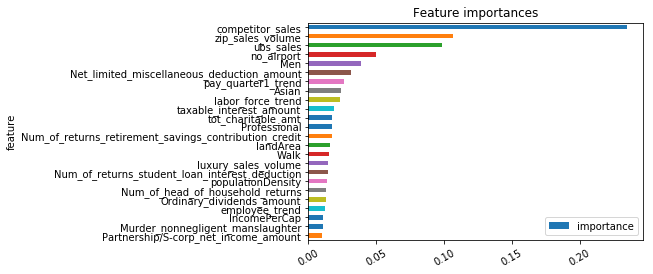

In [151]:
selected_features.plot.barh(x='feature',y='importance').invert_yaxis()
plt.xticks(rotation=30)
#plt.yticks(rotation=10)
plt.rc('ytick', labelsize=10)  
plt.title("Feature importances")


In [65]:
# if we have to change the features we need change this features list

# We can change the model features based on your request


In [152]:
features=['competitor_sales','zip_sales_volume', 'ubs_sales', 'no_airport', 'Men',
 'A20800', 'pay_quarter1_trend', 'Asian', 'labor_force_trend', 'taxable_interest_amount',
 'tot_charitable_amt', 'Professional', 'N07240', 'landArea',
 'Walk','luxury_sales_volume', 'N03210', 'populationDensity',
 'MARS4', 'A00600','employee_trend','IncomePerCap', 'Murder_nonnegligent_manslaughter',
 'A26270']

In [67]:
#features=features[0:len(features)]  # all columns from feature selection

#num=15
#features=features[0:num]  # customized number 

In [166]:
new_data=x[features] #[0:]
new_data.head()

,competitor_sales,zip_sales_volume,ubs_sales,no_airport,Men,A20800,pay_quarter1_trend,Asian,labor_force_trend,taxable_interest_amount,...,Walk,luxury_sales_volume,N03210,populationDensity,MARS4,A00600,employee_trend,IncomePerCap,Murder_nonnegligent_manslaughter,A26270
zip,,,,,,,,,,,,,,,,,,,,,
01608,2.449200e+07,29208000.0,4.716000e+06,3.0,399807.0,1430,13500.457143,4.4,0.0,577,...,2.7,0.0,150,8688,400,5903,878.657143,32284.0,5,1522
01960,0.000000e+00,12974000.0,1.297400e+07,0.0,367791.0,14399,9228.257143,3.4,0.0,13928,...,3.3,17881000.0,2730,3185,2500,30526,228.200000,36212.0,2,42017
02030,0.000000e+00,9583000.0,9.583000e+06,0.0,543986.5,15126,114.885714,10.1,0.0,22678,...,4.2,0.0,80,370,100,72490,11.028571,44990.5,0,170278
02109,1.323587e+08,164634000.0,3.227533e+07,2.0,366767.0,20562,-124785.714286,8.6,0.0,18356,...,13.6,0.0,260,21721,60,81820,-5134.628571,34420.0,57,142912
02110,3.052070e+08,305592000.0,3.850000e+05,9.0,366767.0,28299,192147.028571,8.6,0.0,18882,...,13.6,0.0,60,9355,60,205296,2729.142857,34420.0,57,267117


In [167]:
# skip if we change number of columns
new_data.columns=['competitor_sales', 'zip_sales_volume', 'ubs_sales',
 'no_airport', 'Men', 'Net_limited_miscellaneous_deduction_amount', 'pay_quarter1_trend',
 'Asian', 'labor_force_trend', 'taxable_interest_amount', 'tot_charitable_amt',
 'Professional','Num_of_returns_retirement_savings_contribution_credit',
 'landArea','Walk','luxury_sales_volume','Num_of_returns_student_loan_interest_deduction',
 'populationDensity', 'Num_of_head_of_household_returns',
 'Ordinary_dividends_amount','employee_trend','IncomePerCap',
 'Murder_nonnegligent_manslaughter','Partnership/S-corp_net_income_amount']

In [168]:
new_data.head()

,competitor_sales,zip_sales_volume,ubs_sales,no_airport,Men,Net_limited_miscellaneous_deduction_amount,pay_quarter1_trend,Asian,labor_force_trend,taxable_interest_amount,...,Walk,luxury_sales_volume,Num_of_returns_student_loan_interest_deduction,populationDensity,Num_of_head_of_household_returns,Ordinary_dividends_amount,employee_trend,IncomePerCap,Murder_nonnegligent_manslaughter,Partnership/S-corp_net_income_amount
zip,,,,,,,,,,,,,,,,,,,,,
01608,2.449200e+07,29208000.0,4.716000e+06,3.0,399807.0,1430,13500.457143,4.4,0.0,577,...,2.7,0.0,150,8688,400,5903,878.657143,32284.0,5,1522
01960,0.000000e+00,12974000.0,1.297400e+07,0.0,367791.0,14399,9228.257143,3.4,0.0,13928,...,3.3,17881000.0,2730,3185,2500,30526,228.200000,36212.0,2,42017
02030,0.000000e+00,9583000.0,9.583000e+06,0.0,543986.5,15126,114.885714,10.1,0.0,22678,...,4.2,0.0,80,370,100,72490,11.028571,44990.5,0,170278
02109,1.323587e+08,164634000.0,3.227533e+07,2.0,366767.0,20562,-124785.714286,8.6,0.0,18356,...,13.6,0.0,260,21721,60,81820,-5134.628571,34420.0,57,142912
02110,3.052070e+08,305592000.0,3.850000e+05,9.0,366767.0,28299,192147.028571,8.6,0.0,18882,...,13.6,0.0,60,9355,60,205296,2729.142857,34420.0,57,267117


# second_short_list

In [169]:
second_short_list=pd.read_csv('../Output/short_list_branches.csv')


In [170]:
second_short_list.zip=second_short_list.zip.astype(str).str.zfill(5)
second_short_list.head()

len(second_short_list)

,zip,similarity
0,01002,0.714916
1,01013,0.733400
2,01020,0.788103
3,01040,0.819409
4,01060,0.665426


5777

# Prepare testing data the short listed zipcodes


In [174]:
# testing the short listed zipcodes
#zip_list=list(short_list.zip)

zip_list=list(ubs_city.Zip)+list(second_short_list.zip)
test_dataset=final_complete_table[final_complete_table['zip_x'].isin(zip_list)].drop(['cbsa','city','state','state_code','county'], axis=1).drop_duplicates()
test_dataset=test_dataset.groupby('zip_x').mean().reset_index('zip_x')
test_dataset=test_dataset.set_index('zip_x')


In [175]:
test_dataset.head()
len(test_dataset)

,population,populationDensity,housingUnits,medianHomeValue,occupiedHousingUnits,medianHouseholdIncome,waterArea,landArea,agi_stub,N1,...,COUNTY_FIRM_EMPLOYMENT,"ANNUAL_FIRM_PAYROLL ($1,000)",unemployment_rate_trend,labor_force_trend,no_establishments_trend,employee_trend,pay_quarter1_trend,pay_annual_trend,ubs_sales,competitor_sales
zip_x,,,,,,,,,,,,,,,,,,,,,
01002,29049,528,10388,338900.0,9910,54422.0,1.65,55.04,21,9490,...,124030.0,5145599.0,0.0,0.0,0.428571,638.742857,5178.657143,23209.657143,0.0,0.0
01013,23188,4123,10246,179800.0,9578,41273.0,0.67,5.62,21,10550,...,227956.0,9478767.0,0.0,0.0,1.228571,-34.057143,-338.257143,-811.771429,0.0,0.0
01020,29668,2378,13688,181400.0,13070,51255.0,0.45,12.47,21,15170,...,227956.0,9478767.0,0.0,0.0,3.828571,322.942857,4046.971429,20228.828571,0.0,0.0
01040,39880,1874,16384,187200.0,15361,31628.0,1.55,21.28,21,16540,...,227956.0,9478767.0,0.0,0.0,-3.657143,33.657143,5398.457143,18109.971429,0.0,0.0
01060,15284,1400,7307,305500.0,6782,52607.0,1.26,10.92,21,7360,...,227956.0,9478767.0,0.0,0.0,0.085714,159.114286,3275.114286,17635.085714,0.0,2583000.0


6084

In [176]:
test_dataset=test_dataset[features]

test_dataset.columns=['competitor_sales','zip_sales_volume', 'ubs_sales', 'no_airport',
 'Men','Net_limited_miscellaneous_deduction_amount','pay_quarter1_trend', 'Asian',
 'labor_force_trend', 'taxable_interest_amount', 'tot_charitable_amt',
 'Professional', 'Num_of_returns_retirement_savings_contribution_credit',
 'landArea', 'Walk', 'luxury_sales_volume', 'Num_of_returns_student_loan_interest_deduction',
 'populationDensity', 'Num_of_head_of_household_returns',
 'Ordinary_dividends_amount', 'employee_trend', 'IncomePerCap',
 'Murder_nonnegligent_manslaughter','Partnership/S-corp_net_income_amount']

test_dataset.head()

,competitor_sales,zip_sales_volume,ubs_sales,no_airport,Men,Net_limited_miscellaneous_deduction_amount,pay_quarter1_trend,Asian,labor_force_trend,taxable_interest_amount,...,Walk,luxury_sales_volume,Num_of_returns_student_loan_interest_deduction,populationDensity,Num_of_head_of_household_returns,Ordinary_dividends_amount,employee_trend,IncomePerCap,Murder_nonnegligent_manslaughter,Partnership/S-corp_net_income_amount
zip_x,,,,,,,,,,,,,,,,,,,,,
01002,0.0,0.0,0.0,0.0,55022.5,7420,5178.657143,3.4,0.0,7172,...,6.95,0.0,920,528,750,35049,638.742857,30414.0,0,45364
01013,0.0,0.0,0.0,0.0,225611.0,2530,-338.257143,2.1,0.0,2774,...,2.60,0.0,990,4123,2020,2320,-34.057143,26560.0,3,3503
01020,0.0,0.0,0.0,0.0,225611.0,3728,4046.971429,2.1,0.0,4902,...,2.60,0.0,1450,2378,2040,3977,322.942857,26560.0,3,7002
01040,0.0,0.0,0.0,0.0,225611.0,3687,5398.457143,2.1,0.0,3592,...,2.60,0.0,1420,1874,3770,6100,33.657143,26560.0,4,19440
01060,2583000.0,2583000.0,0.0,1.0,75286.0,5193,3275.114286,5.3,0.0,4306,...,9.20,0.0,1160,1400,490,19619,159.114286,30244.0,0,34494


In [177]:

# all machine learning algorithm will test on this dataset: 
feature_scaler = StandardScaler()  
short_list_city = feature_scaler.fit_transform(test_dataset)  

In [178]:
len(test_dataset)
test_dataset.head()

6084

,competitor_sales,zip_sales_volume,ubs_sales,no_airport,Men,Net_limited_miscellaneous_deduction_amount,pay_quarter1_trend,Asian,labor_force_trend,taxable_interest_amount,...,Walk,luxury_sales_volume,Num_of_returns_student_loan_interest_deduction,populationDensity,Num_of_head_of_household_returns,Ordinary_dividends_amount,employee_trend,IncomePerCap,Murder_nonnegligent_manslaughter,Partnership/S-corp_net_income_amount
zip_x,,,,,,,,,,,,,,,,,,,,,
01002,0.0,0.0,0.0,0.0,55022.5,7420,5178.657143,3.4,0.0,7172,...,6.95,0.0,920,528,750,35049,638.742857,30414.0,0,45364
01013,0.0,0.0,0.0,0.0,225611.0,2530,-338.257143,2.1,0.0,2774,...,2.60,0.0,990,4123,2020,2320,-34.057143,26560.0,3,3503
01020,0.0,0.0,0.0,0.0,225611.0,3728,4046.971429,2.1,0.0,4902,...,2.60,0.0,1450,2378,2040,3977,322.942857,26560.0,3,7002
01040,0.0,0.0,0.0,0.0,225611.0,3687,5398.457143,2.1,0.0,3592,...,2.60,0.0,1420,1874,3770,6100,33.657143,26560.0,4,19440
01060,2583000.0,2583000.0,0.0,1.0,75286.0,5193,3275.114286,5.3,0.0,4306,...,9.20,0.0,1160,1400,490,19619,159.114286,30244.0,0,34494


In [179]:
test_dataset.to_csv('test_dataset.csv')

In [180]:
# import method for split train/test data set
from sklearn.model_selection import train_test_split

# import method to calculate metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# import cross validation method
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC

from sklearn_evaluation import plot
from sklearn_evaluation import table
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Algorithms
1. Logistic Regression 
2. SVM: support vector machine 
3. KNN: K-nearests neighbor
4. Random Forest
5. XG Boost
6. Stacking 

## 1. use existing labeled locations to train the model then test with possible data

In [181]:
# optimize the random forest parameter, for later testing
X_train, X_test, y_train, y_test = train_test_split(new_data,y, test_size=0.3, random_state=0)

feature_scaler = StandardScaler()  
X_train = feature_scaler.fit_transform(X_train)  
X_test = feature_scaler.transform(X_test)  


In [182]:
# logsistic regression
lg_clf = LogisticRegression()

grid_param = {  
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty':['l2'] ,
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lg_grid_search = GridSearchCV(estimator=lg_clf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5)

lg_grid_search.fit(X_train, y_train) 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [183]:
# SVM

Cs = [0.001, 0.01, 0.1, 1, 10]  #Penalty parameter C of the error term.
gammas = [0.001, 0.01, 0.1, 1]  #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
kernels=['poly', 'rbf', 'sigmoid']
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel':kernels}

svm=SVC(probability=True)

SVM_grid_search = GridSearchCV(svm, param_grid, cv=5,scoring = 'accuracy')

SVM_grid_search.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['poly', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [184]:
# KNN

k_range = list(range(1,30))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv = 5, scoring = 'accuracy')
knn_grid_search.fit(X_train, y_train)



/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [185]:
# Random forest
rf_clf = RandomForestClassifier() 

grid_param = {  
    'n_estimators': [10,100,1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]}

rf_grid_search= GridSearchCV(estimator=rf_clf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5)

rf_grid_search.fit(X_train, y_train) 


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 1000], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [186]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGradient Boost
xg_clf = xgb.XGBClassifier()

grid_param = {
    'n_estimators': [100, 250, 500],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0]}

xg_grid_search= GridSearchCV(estimator=xg_clf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5)

xg_grid_search.fit(X_train, y_train) 



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an err

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 250, 500], 'max_depth': [6, 9, 12], 'subsample': [0.9, 1.0], 'colsample_bytree': [0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### plot after trained random forest's confusion matrix
### report accuracy & optimized parameters 

<img src="../Picture/train_model.PNG" width="90%">

<img src="../Picture/model_result.PNG" width="90%">

<img src="../Picture/model_condition.PNG" width="90%">

In [85]:
# just to make sure table have same attributes, repeated attributes will be naturelly deleted from previous feature selection
#final_complete_table=final_table.merge(branch_sales,how='left',left_on='zip_x', right_on='zip').fillna(0).drop(['zip','branch'],axis=1)
#final_complete_table.to_csv('final_complete_table.csv',index=False)


 Logistic regression accuracy after optimization: 
 0.95

 Logistic regression optimized parameters: 
 {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


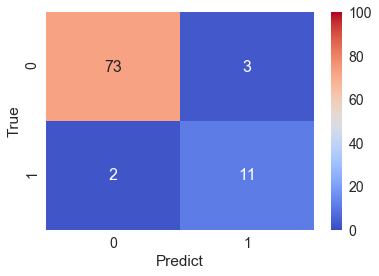

In [187]:
print ("\n Logistic regression accuracy after optimization: \n", round(lg_grid_search.best_score_ ,2)) 
print ("\n Logistic regression optimized parameters: \n", lg_grid_search.best_params_)  

lg_y_test_pred=lg_grid_search.predict(X_test)
lg_df=pd.DataFrame(confusion_matrix(y_test, lg_y_test_pred))

# logistic regression's confusion matrix

sns.set(font_scale=1.4)#for label size
lg_confusion_matrix=sns.heatmap(lg_df, annot=True,annot_kws={"size": 16},cmap='coolwarm',
                                 vmin=0, vmax=100).set(xlabel='Predict', ylabel='True')


 SVM accuracy after optimization: 
 0.95

 SVM optimized parameters: 
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


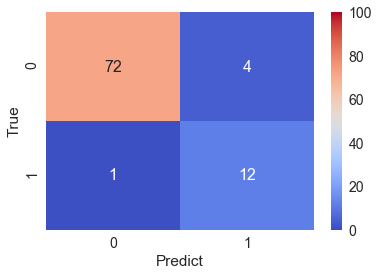

In [188]:
print ("\n SVM accuracy after optimization: \n", round(SVM_grid_search.best_score_,2))
print ("\n SVM optimized parameters: \n", SVM_grid_search.best_params_)

svm_y_test_pred=SVM_grid_search.predict(X_test)
svm_df=pd.DataFrame(confusion_matrix(y_test, svm_y_test_pred))

sns.set(font_scale=1.4)#for label size
svm_confusion_matrix=sns.heatmap(svm_df, annot=True,annot_kws={"size": 16},cmap='coolwarm',
                                 vmin=0, vmax=100).set(xlabel='Predict', ylabel='True')


 KNN accuracy after optimization: 
 0.9

 KNN optimized parameters: 
 {'n_neighbors': 4, 'weights': 'distance'}


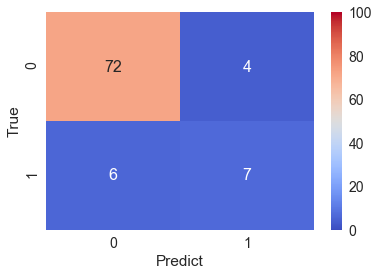

In [189]:
print ("\n KNN accuracy after optimization: \n", round(knn_grid_search.best_score_,2))
print ("\n KNN optimized parameters: \n", knn_grid_search.best_params_)

knn_y_test_pred=knn_grid_search.predict(X_test)
knn_df=pd.DataFrame(confusion_matrix(y_test, knn_y_test_pred))

sns.set(font_scale=1.4)#for label size

knn_confusion_matrix=sns.heatmap(knn_df,annot=True,annot_kws={"size": 16},cmap='coolwarm',
                                 vmin=0, vmax=100).set(xlabel='Predict', ylabel='True')




 Random forest accuracy after optimization: 
 0.97

 Random forest optimized parameters: 
 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}


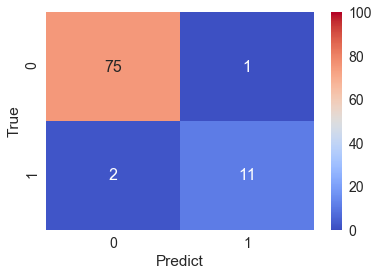

In [190]:
print ("\n Random forest accuracy after optimization: \n", round(rf_grid_search.best_score_,2))
print ("\n Random forest optimized parameters: \n", rf_grid_search.best_params_)

y_test_pred=rf_grid_search.predict(X_test)
rf_df=pd.DataFrame(confusion_matrix(y_test, y_test_pred))

sns.set(font_scale=1.4)#for label size

rf_confusion_matrix=sns.heatmap(rf_df, annot=True,annot_kws={"size": 16},\
                                cmap='coolwarm', vmin=0, vmax=100).set(xlabel='Predict', ylabel='True')



 XG Boost accuracy after optimization: 
 0.97

 XG Boost optimized parameters: 
 {'colsample_bytree': 0.9, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


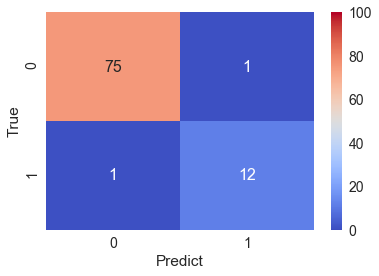

In [191]:
print ("\n XG Boost accuracy after optimization: \n", round(xg_grid_search.best_score_,2))
print ("\n XG Boost optimized parameters: \n", xg_grid_search.best_params_)

xg_y_test_pred=xg_grid_search.predict(X_test)
xg_df=pd.DataFrame(confusion_matrix(y_test, xg_y_test_pred))

sns.set(font_scale=1.4)#for label size

xg_confusion_matrix=sns.heatmap(xg_df, annot=True,annot_kws={"size": 16},\
                                cmap='coolwarm', vmin=0, vmax=100).set(xlabel='Predict', ylabel='True')


In [192]:
from mlxtend.classifier import StackingClassifier

#  models from previous optimization

clf1 = LogisticRegression(penalty = 'l2', C =10, solver='liblinear')

clf2 = SVC(probability=True,C= 10, gamma=0.01, kernel='rbf')
           
clf3 = KNeighborsClassifier(n_neighbors=4, weights='distance')
           
clf4 = RandomForestClassifier(bootstrap=True, criterion= 'entropy', n_estimators=1000)

clf5 = xgb.XGBClassifier(colsample_bytree=0.9, max_depth= 6, n_estimators=100, subsample= 0.9)
           
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3,clf4, clf5], 
                          meta_classifier=clf1)

sclf.fit(X_train, y_train)


#print('5-fold cross validation:\n')

#for clf, label in zip([clf1, clf2, clf3,clf4,clf5, sclf], 
#                      ['logistic regression','SVM','KNN', 
#                       'Random Forest',
#                       'StackingClassifier']):

#    scores = cross_val_score(sclf, X_train, y_train,
#                                              cv=5, scoring='accuracy')
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#          % (scores.mean(), scores.std(), label))


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/mlxtend/classifier/stacking_classification.py:149: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf.fit(X, y)
/anaconda3/lib/python3.6/site-packages/mlxtend/classifier/stacking_classification.py:149: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

StackingClassifier(average_probas=False,
          classifiers=[LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), SVC(C=10, cache_size=2...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)],
          meta_classifier=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [193]:
# stacking results
y_test_pred=sclf.predict(X_test)
accuracy_score(y_test, y_test_pred)

pd.DataFrame(confusion_matrix(y_test, y_test_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9775280898876404

,0,1
0,75,1
1,1,12


# Testing data to each trained model:


In [194]:
lg_test_pred=pd.DataFrame(lg_grid_search.predict_proba(short_list_city)) 
lg_test_pred['zip']=test_dataset.index

lg_test_pred.columns=['lg_no','lg_yes','zip']
lg_test_pred['zip']=lg_test_pred['zip'].astype(str).str.zfill(5)

lg_test_pred.sort_values('lg_yes', ascending=False ).head()

,lg_no,lg_yes,zip
3069,0.0,1.0,46240
3909,0.0,1.0,68154
1395,0.0,1.0,20005
5929,0.0,1.0,98004
1396,0.0,1.0,20006


In [195]:
svm_test_pred=pd.DataFrame(SVM_grid_search.predict_proba(short_list_city)) 
svm_test_pred['zip']=test_dataset.index
svm_test_pred.columns=['svm_no','svm_yes','zip']
svm_test_pred['zip']=svm_test_pred['zip'].astype(str).str.zfill(5)

svm_test_pred.sort_values('svm_yes', ascending=False ).head()
len(svm_test_pred)


,svm_no,svm_yes,zip
5238,3.000001e-14,1.0,92101
1361,3.000001e-14,1.0,19428
3502,3.039658e-14,1.0,55437
1689,3.781385e-14,1.0,23219
3909,6.479887e-14,1.0,68154


6084

In [196]:
knn_test_pred=pd.DataFrame(knn_grid_search.predict_proba(short_list_city)) 
knn_test_pred['zip']=test_dataset.index
knn_test_pred.columns=['knn_no','knn_yes','zip']
knn_test_pred['zip']=knn_test_pred['zip'].astype(str).str.zfill(5)

knn_test_pred.sort_values('knn_yes', ascending=False ).head()

,knn_no,knn_yes,zip
4421,0.0,1.0,78216
5548,0.0,1.0,94104
5873,0.0,1.0,97204
5874,0.0,1.0,97205
3563,0.0,1.0,60010


In [197]:
# test on the possible 
rf_test_pred=pd.DataFrame(rf_grid_search.predict_proba(short_list_city)) 
rf_test_pred['zip']=test_dataset.index
rf_test_pred.columns=['rf_no','rf_yes','zip']
rf_test_pred['zip']=rf_test_pred['zip'].astype(str).str.zfill(5)

rf_test_pred.sort_values('rf_yes', ascending=False ).head()

,rf_no,rf_yes,zip
431,0.01,0.99,07086
2289,0.02,0.98,32801
225,0.02,0.98,02903
5874,0.02,0.98,97205
5967,0.02,0.98,98104


In [198]:
# test on the possible 
xg_test_pred=pd.DataFrame(xg_grid_search.predict_proba(short_list_city)) 
xg_test_pred['zip']=test_dataset.index
xg_test_pred.columns=['xg_no','xg_yes','zip']
xg_test_pred['zip']=xg_test_pred['zip'].astype(str).str.zfill(5)

xg_test_pred.sort_values('xg_yes', ascending=False ).head()

,xg_no,xg_yes,zip
5359,0.003152,0.996848,92660
5622,0.003471,0.996529,94596
5081,0.003701,0.996299,91101
494,0.003742,0.996258,07652
5524,0.003771,0.996229,94025


In [199]:
sclf_test_pred=pd.DataFrame(sclf.predict_proba(short_list_city)) 
len(sclf_test_pred)
sclf_test_pred['zip']=test_dataset.index

len(sclf_test_pred)
sclf_test_pred.columns=['stack_no','stack_yes','zip']
sclf_test_pred['zip']=sclf_test_pred['zip'].astype(str).str.zfill(5)

sclf_test_pred.sort_values('stack_yes', ascending=False ).head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


6084

6084

,stack_no,stack_yes,zip
1588,0.005271,0.994729,21601
1674,0.005271,0.994729,22902
560,0.005271,0.994729,07960
5630,0.005271,0.994729,94607
5631,0.005271,0.994729,94612


In [225]:
# check with ubs locations
#rf_test_pred[rf_test_pred.index.isin(ubs_city.zip)].sort_values('rf_yes', ascending=False )#.to_csv('check.csv')

In [200]:
len(rf_test_pred)

merged_df = pd.merge(rf_test_pred,knn_test_pred, on='zip',how='left')
merged_df = pd.merge(merged_df,svm_test_pred, on='zip',how='left')
merged_df = pd.merge(merged_df,lg_test_pred, on='zip',how='left')
merged_df = pd.merge(merged_df,xg_test_pred, on='zip',how='left')
merged_df = pd.merge(merged_df,sclf_test_pred, on='zip',how='left')

len(merged_df)

merged_df.head()


6084

6084

,rf_no,rf_yes,zip,knn_no,knn_yes,svm_no,svm_yes,lg_no,lg_yes,xg_no,xg_yes,stack_no,stack_yes
0,0.96,0.04,01002,1.000000,0.000000,0.857800,0.142200,0.985835,0.014165,0.996475,0.003525,0.995649,0.004351
1,0.99,0.01,01013,1.000000,0.000000,0.996685,0.003315,0.999626,0.000374,0.998347,0.001653,0.995649,0.004351
2,0.99,0.01,01020,1.000000,0.000000,0.993303,0.006697,0.999332,0.000668,0.998392,0.001608,0.995649,0.004351
3,0.98,0.02,01040,1.000000,0.000000,0.994914,0.005086,0.998947,0.001053,0.998487,0.001513,0.995649,0.004351
4,0.99,0.01,01060,0.764057,0.235943,0.547833,0.452167,0.951418,0.048582,0.997135,0.002865,0.995649,0.004351


In [201]:
merged_df=merged_df[['zip','rf_no','rf_yes',
                    'knn_no','knn_yes','svm_no','svm_yes',
                    'lg_no','lg_yes','xg_no','xg_yes','stack_no','stack_yes']]
merged_df.to_csv('../Output/merged_df.csv',index=False)

<img src="../Picture/results_vali.PNG" width="90%">

# Final neural network and scoring methods to determin the zipcodes!
- Combine all 6 methods output
- Use Neural network
- Use average scores

In [207]:
# let the UBS zipcode with possibility >0.8 as training 
ubs_city_classification=merged_df[merged_df.zip.isin(ubs_city.Zip)]
ubs_city_classification=ubs_city_classification[(ubs_city_classification.lg_yes>=0.7)]
len(ubs_city_classification)
ubs_city_classification['target']='1'

possible_data_no_ubs_zip=merged_df[~merged_df.zip.isin(ubs_city.Zip)]


215

In [205]:

no_branch_data=possible_data_no_ubs_zip[(possible_data_no_ubs_zip.xg_yes<=0.0019)]
no_branch_data['target']='0'
len(no_branch_data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


996

In [208]:
# combine 2 dataset for training:
# use Neural Network algorithm

ann_dataset=ubs_city_classification.append(no_branch_data)
ann_dataset=ann_dataset[['zip','rf_yes','knn_yes','svm_yes','lg_yes','xg_yes','stack_yes','target']]

ann_dataset=ann_dataset.set_index('zip')
len(ann_dataset)
ann_dataset.head()

1211

,rf_yes,knn_yes,svm_yes,lg_yes,xg_yes,stack_yes,target
zip,,,,,,,
01608,0.93,0.778148,0.999995,0.999956,0.979280,0.994729,1
01960,0.46,0.000000,0.950330,0.994537,0.195398,0.082405,1
02109,0.89,1.000000,0.576556,1.000000,0.987238,0.994729,1
02110,0.91,1.000000,0.090415,1.000000,0.987880,0.976143,1
02116,0.67,0.677406,0.103768,0.999774,0.718736,0.976143,1


In [209]:
# create non-city data as training 
possible_data_no_ubs_zip=possible_data_no_ubs_zip[['zip','rf_yes','knn_yes',
                                                   'svm_yes','lg_yes','xg_yes','stack_yes']].set_index('zip')
possible_data_no_ubs_zip.head()

,rf_yes,knn_yes,svm_yes,lg_yes,xg_yes,stack_yes
zip,,,,,,
01002,0.04,0.000000,0.142200,0.014165,0.003525,0.004351
01013,0.01,0.000000,0.003315,0.000374,0.001653,0.004351
01020,0.01,0.000000,0.006697,0.000668,0.001608,0.004351
01040,0.02,0.000000,0.005086,0.001053,0.001513,0.004351
01060,0.01,0.235943,0.452167,0.048582,0.002865,0.004351


# average scores method to predict possible locations


In [210]:
possible_zipcodes=possible_data_no_ubs_zip[['rf_yes','knn_yes','svm_yes','lg_yes','xg_yes','stack_yes']]
possible_zipcodes['score']=possible_zipcodes.mean(axis=1)

In [211]:
possible_zipcodes.sort_values('score',ascending=False).head()

,rf_yes,knn_yes,svm_yes,lg_yes,xg_yes,stack_yes,score
zip,,,,,,,
80111,0.95,1.0,0.999996,1.000000,0.994324,0.994729,0.989842
11021,0.93,1.0,1.000000,1.000000,0.993765,0.994729,0.986416
60523,0.92,1.0,1.000000,0.999998,0.994721,0.994729,0.984908
63131,0.92,1.0,1.000000,1.000000,0.990312,0.994729,0.984174
19087,0.91,1.0,0.999997,1.000000,0.993140,0.994729,0.982978


### Build neural network model for final classification

In [212]:
ann_x=ann_dataset.drop(['target'],axis=1)
ann_y=ann_dataset.target

In [213]:
from sklearn.neural_network import MLPClassifier

ann_X_train, ann_X_test, ann_y_train, ann_y_test = train_test_split(ann_x,ann_y, test_size=0.3, random_state=42)

feature_scaler = StandardScaler()  

ann_X_train = feature_scaler.fit_transform(ann_X_train)  
ann_X_test = feature_scaler.transform(ann_X_test)  


In [214]:

ann_clf = MLPClassifier(max_iter=1000,random_state=0)

grid_param={'learning_rate': ["constant", "adaptive"],
'hidden_layer_sizes': [(5,2),(20,2)],
'alpha': [0.0001, 0.05],
'activation': ["logistic", "relu"]
}

ann_grid_search= GridSearchCV(estimator=ann_clf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5)

ann_grid_search.fit(ann_X_train, ann_y_train) 


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': ['constant', 'adaptive'], 'hidden_layer_sizes': [(5, 2), (20, 2)], 'alpha': [0.0001, 0.05], 'activation': ['logistic', 'relu']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)


 ANN accuracy after optimization: 
 1.0

 ANN optimized parameters: 
 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'learning_rate': 'constant'}


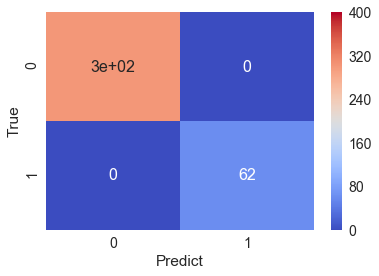

In [215]:
print ("\n ANN accuracy after optimization: \n", ann_grid_search.best_score_)
print ("\n ANN optimized parameters: \n", ann_grid_search.best_params_)

ann_y_test_pred=ann_grid_search.predict(ann_X_test)
#accuracy_score(y_true, y_pred.round(), normalize=False)

ann_df=pd.DataFrame(confusion_matrix(ann_y_test, ann_y_test_pred))

sns.set(font_scale=1.4)#for label size

ann_confusion_matrix=sns.heatmap(ann_df, annot=True,annot_kws={"size": 16},\
                                cmap='coolwarm', vmin=0, vmax=400).set(xlabel='Predict', ylabel='True')

In [216]:
feature_scaler = StandardScaler()  

ann_test= feature_scaler.fit_transform(possible_data_no_ubs_zip)  

ann_test_pred=pd.DataFrame(ann_grid_search.predict_proba(ann_test))

ann_test_pred['zip']=possible_data_no_ubs_zip.index
ann_test_pred.columns=['ann_no','ann_yes','zip']
ann_test_pred['zip']=ann_test_pred['zip'].astype(str).str.zfill(5)

ann_test_pred.sort_values('ann_yes', ascending=False ).head()
len(ann_test_pred)


,ann_no,ann_yes,zip
4357,0.137719,0.862281,80111
2048,0.137719,0.862281,30342
800,0.137719,0.862281,11021
3597,0.137719,0.862281,63017
3475,0.137719,0.862281,60523


5777

In [217]:
ann_test_pred.to_csv('../Output/ann_output.csv',index=False)
possible_zipcodes.to_csv('../Output/average_score_output.csv',index=True)

In [218]:
final_table.zip_x=final_table.zip_x.astype(str).str.zfill(5)
ann_result=ann_test_pred.merge(final_table, left_on='zip',right_on='zip_x')
#ann_result.sort_values('ann_yes',ascending=False).head()

ann_reduced_result=ann_result[['ann_no','ann_yes','zip','cbsa','city','state','state_code','county']]
#len(ann_reduced_result)
ann_reduced_result.sort_values('ann_yes',ascending=False).head()

,ann_no,ann_yes,zip,cbsa,city,state,state_code,county
4850,0.137719,0.862281,80111,19740,Englewood,Colorado,CO,Arapahoe County
2211,0.137719,0.862281,30342,12060,Atlanta,Georgia,GA,Fulton County
843,0.137719,0.862281,11021,35620,Great Neck,New York,NY,Nassau County
4007,0.137719,0.862281,63017,41180,Chesterfield,Missouri,MO,St. Louis County
3879,0.137719,0.862281,60523,16980,Oak Brook,Illinois,IL,DuPage County


In [219]:
ann_candidate_result=ann_reduced_result[(ann_reduced_result.ann_yes>=0.809)]
len(ann_candidate_result.city.unique())


ann_candidate_result['ann_Rank'] = ann_candidate_result['ann_yes'].rank(ascending=False, method='dense')

ann_candidate_result=ann_candidate_result.sort_values('ann_Rank',ascending=True)
ann_candidate_result.to_csv('../Output/ann_candidate_result.csv')


377

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [220]:
compet=exist_branches[(exist_branches['Company Name']!='UBS')]
compet.City.head()

419     Anchorage
420        Juneau
421      Anniston
422    Birmingham
423    Birmingham
Name: City, dtype: object

In [225]:
ubs_city.City

0             Anchorage
1            Birmingham
2            Huntsville
3            Montgomery
4        Vestavia Hills
5           Little Rock
6               Phoenix
7            Scottsdale
8            Scottsdale
9                Sedona
10             Surprise
11               Tucson
12          Bakersfield
13        Beverly Hills
14                 Brea
15               Carmel
16                Chico
17               Encino
18               Fresno
19         Grass Valley
20         Indian Wells
21               Irvine
22             LA Jolla
23          Los Angeles
24          Los Angeles
25          Los Angeles
26            Los Gatos
27           Menlo Park
28               Merced
29          Mill Valley
             ...       
306               Tyler
307                Waco
308           Park City
309      Salt Lake City
310         South Ogden
311             Norfolk
312            Richmond
313             Roanoke
314              Vienna
315      Virginia Beach
316             

In [226]:
ann_reduced_result=ann_candidate_result[['zip','city','state','ann_Rank']]
ann_reduced_result=ann_reduced_result.replace('Saint Louis','St. Louis')
#ann_candidate_result=
ann_reduced_result['UBS_city']=np.where(ann_reduced_result['city'].isin(ubs_city.City), 'Yes','No')
ann_reduced_result['Competitor_city']=np.where(ann_reduced_result['city'].isin(compet.City), 'Yes','No')

#df['one'] = np.where(df['name'].isin(['a', 'b']), 100, df['two'])

#

ann_reduced_result.to_csv('../Output/ann_candidate_result.csv')

# ANN results 

In [268]:
#ann_candidate_result.head(15)

# scored possible zipcode

In [227]:
possible_zipcodes=possible_zipcodes.reset_index()

In [228]:
#possible_zipcodes=possible_zipcodes.reset_index()
scoring_result=possible_zipcodes.merge(final_table, left_on='zip',right_on='zip_x')
score_reduced_result=scoring_result[['score','zip','cbsa','city','state','county']]
len(score_reduced_result)
score_reduced_result=score_reduced_result.sort_values('score',ascending=False)

6359

In [229]:
score_candidate_result=score_reduced_result[(score_reduced_result.score>=0.7)].sort_values('score',ascending=False)
len(score_candidate_result.city.unique())
score_candidate_result['score_Rank'] = score_candidate_result['score'].rank(method='dense',ascending=False)


197

In [231]:

score_candidate_result=score_candidate_result.replace('Saint Louis','St. Louis')
score_candidate_result['UBS_city']=np.where(score_candidate_result['city'].isin(ubs_city.City), 'Yes','No')
score_candidate_result['Competitor_city']=np.where(score_candidate_result['city'].isin(compet.City), 'Yes','No')

#df['one'] = np.where(df['name'].isin(['a', 'b']), 100, df['two'])

score_candidate_result=score_candidate_result.drop(['score','cbsa','county'],axis=1)

score_candidate_result.to_csv('../Output/score_candidate_result.csv')

In [232]:
# average method

print("\n Scoring method result cities: \n")  
score_candidate_result.head(15)


 Scoring method result cities: 



,zip,city,state,score_Rank,UBS_city,Competitor_city
4850,80111,Englewood,Colorado,1.0,No,No
843,11021,Great Neck,New York,2.0,No,Yes
3879,60523,Oak Brook,Illinois,3.0,No,Yes
4035,63131,St. Louis,Missouri,4.0,Yes,No
1312,19087,Wayne,Pennsylvania,5.0,No,Yes
5388,91367,Woodland Hills,California,6.0,No,Yes
4373,75093,Plano,Texas,7.0,Yes,Yes
1639,22102,Mc Lean,Virginia,8.0,No,Yes
556,07960,Morristown,New Jersey,9.0,No,Yes
778,10549,Mount Kisco,New York,10.0,No,Yes


In [233]:
print("\n Neural Network method result cities: \n")
ann_reduced_result.head(15)


 Neural Network method result cities: 



,zip,city,state,ann_Rank,UBS_city,Competitor_city
4850,80111,Englewood,Colorado,1.0,No,No
2211,30342,Atlanta,Georgia,2.0,Yes,Yes
843,11021,Great Neck,New York,3.0,No,Yes
4007,63017,Chesterfield,Missouri,4.0,Yes,Yes
3879,60523,Oak Brook,Illinois,5.0,No,Yes
4035,63131,St. Louis,Missouri,6.0,Yes,No
5386,91362,Thousand Oaks,California,7.0,No,No
5385,91362,Thousand Oaks,California,7.0,No,No
5910,94901,San Rafael,California,8.0,No,Yes
4373,75093,Plano,Texas,9.0,Yes,Yes


In [234]:
final=score_candidate_result.merge(ann_reduced_result, on='zip').drop_duplicates()
final=final[['zip','city_x','state_x','score_Rank','ann_Rank','UBS_city_x','Competitor_city_x']]
final.head()

,zip,city_x,state_x,score_Rank,ann_Rank,UBS_city_x,Competitor_city_x
0,80111,Englewood,Colorado,1.0,1.0,No,No
1,11021,Great Neck,New York,2.0,3.0,No,Yes
2,60523,Oak Brook,Illinois,3.0,5.0,No,Yes
3,63131,St. Louis,Missouri,4.0,6.0,Yes,No
4,19087,Wayne,Pennsylvania,5.0,10.0,No,Yes


In [273]:
# not competitor branch neither UBS branch
ann_reduced_result[(ann_reduced_result.UBS_city=='No') & (ann_reduced_result.Competitor_city=='No')].drop_duplicates().head(10)

,zip,city,state,ann_Rank,UBS_city,Competitor_city
4893,80111,Englewood,Colorado,1.0,No,No
5436,91362,Thousand Oaks,California,68.0,No,No
1565,21093,Lutherville Timonium,Maryland,76.0,No,No
2469,33065,Pompano Beach,Florida,97.0,No,No
1322,19067,Morrisville,Pennsylvania,158.0,No,No
1078,12065,Clifton Park,New York,225.0,No,No
1089,12309,Schenectady,New York,276.0,No,No
115,02072,Stoughton,Massachusetts,285.0,No,No
3980,60706,Harwood Heights,Illinois,287.0,No,No
5309,90232,Culver City,California,293.0,No,No


<img src="../Picture/result.PNG" width="90%">

# Calculate the distance between branches to new location

In [243]:
import pandas as pd

from geopy.distance import geodesic
from geopy.distance import vincenty
# read in csv file
zip_loc = pd.read_csv('../Data/us_zip_lat_long.txt', sep = ',')

zip_loc.ZIP=zip_loc.ZIP.astype(str).str.zfill(5)

In [239]:
result_cities=final.merge(zip_loc, left_on='zip',right_on='ZIP', how='left').drop(['ZIP'],axis=1)
ubs_cities=zip_loc[(zip_loc['ZIP'].isin(ubs_city.Zip))]
result_cities=result_cities.set_index('zip')
ubs_cities=ubs_cities.set_index('ZIP')

ubs_cities['location']=list(zip(ubs_cities['LAT'],ubs_cities['LNG']))
result_cities['location']=list(zip(result_cities['LAT'],result_cities['LNG']))

In [310]:
result_cities.head(3)

,city_x,state_x,score_Rank,ann_Rank,UBS_city_x,Competitor_city_x,LAT,LNG,loc,location
zip,,,,,,,,,,
80111,Englewood,Colorado,1.0,1.0,No,No,39.613005,-104.877957,"(39.613005, -104.87795700000001)","(39.613005, -104.87795700000001)"
11021,Great Neck,New York,2.0,3.0,No,Yes,40.784319,-73.731488,"(40.784319, -73.731488)","(40.784319, -73.731488)"
60523,Oak Brook,Illinois,3.0,5.0,No,Yes,41.836558,-87.953278,"(41.836558000000004, -87.953278)","(41.836558000000004, -87.953278)"


In [244]:
import mpu
def distance(point1, point2):
    return geodesic(point1, point2).miles
def closest(data, this_point):
    return min(data, key=lambda x: distance(this_point, x))

In [296]:
data_1=ubs_cities['location']
ubs_zip_dict=data_1.to_dict()

In [303]:
def final_dist(data1, pred_loc):
    loc=closest(data1,pred_loc)
    dist=distance(pred_loc,loc)
    return loc,dist

In [311]:
#[2 means the 3rd location]
pred_location=[result_cities.location][0][2]

In [312]:
dist_to_ubs_branch=list(final_dist(data_1, pred_location))
dist_to_ubs_branch
zip_pred_ubs=ubs_cities[(ubs_cities['loc']==dist_to_ubs_branch[0])].reset_index()


[(41.876897, -87.97632800000001), 3.027422687262827]

In [313]:
zip_pred_ubs
ubs_city[(ubs_city.Zip==zip_pred_ubs['ZIP'][0])]

,ZIP,LAT,LNG,loc,location
0,60181,41.876897,-87.976328,"(41.876897, -87.97632800000001)","(41.876897, -87.97632800000001)"


,City,State,Zip
111,Oak Brook Terrace,IL,60181
112,Oakbrook Terrace,IL,60181


<img src="../Picture/thank_you.PNG" width="90%">

<img src="../Picture/appendix1.PNG" width="90%">

<img src="../Picture/appendix2.PNG" width="90%">

<img src="../Picture/appendix3.PNG" width="90%">

<img src="../Picture/appendix4.PNG" width="90%">